# Video Game Sales

### The global video game industry is a billion-dollar business and has been for many years. In 2022, the revenue from the worldwide gaming market was estimated at almost 347 billion U.S. dollars, with the mobile gaming market generating an estimated 248 billion U.S. dollars of the total. (https://www.statista.com/topics/868/video-games/)   

#### By analyzing variables connected to previously released games, there might be a possibility to train a machine learning model to help predict future sales, and also what kind of games would generate the most money.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# https://www.kaggle.com/datasets/rush4ratio/video-game-sales-with-ratings/data
video_games_sales=pd.read_csv("Video_Games_Sales_as_at_22_Dec_2016.csv")

# EDA

In [3]:
# Global_Sales will be the predictor variable in this case.
video_games_sales.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


### Explaining the column names

From the data info:

Fields include:
   
    Name - The games name    
    Platform - Platform of the games release (i.e. PC,PS4, etc.)    
    Year - Year of the game's release
    Genre - Genre of the game
    Publisher - Publisher of the game
    NA_Sales - Sales in North America (in millions)
    EU_Sales - Sales in Europe (in millions)
    JP_Sales - Sales in Japan (in millions)
    Other_Sales - Sales in the rest of the world (in millions)
    Global_Sales - Total worldwide sales.
    Critic_score - Aggregate score compiled by Metacritic staff
    Critic_count - The number of critics used in coming up with the Critic_score
    User_score - Score by Metacritic's subscribers
    User_count - Number of users who gave the user_score
    Developer - Party responsible for creating the game
    Rating - The ESRB ratings


In [4]:
# There seems to be missing values, especially at the score columns. 
# Column 13, User_Count, is missing more than 50% of the total values.
# Strings are in object type, which might be ok?
# User_Score are of type object and not float like Critics_Score.
video_games_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


In [5]:
# Missing values:
# Name, Year_of_Release and other columns with smaller count might have their rows dropped.
# The score columns are not easily dropped without risking an underfitted model.
video_games_sales.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         6704
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

### What score values are missing, and why? (Chart)

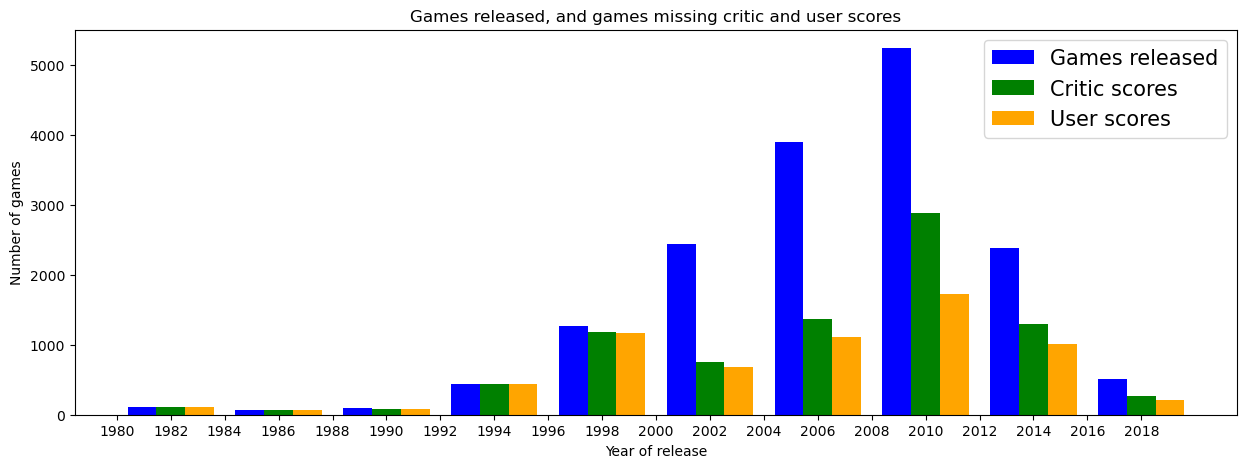

In [6]:
# What score values are missing, and why?
# Here we see that many games around the year 2010 are missing scores, and not many games in the years pre-2000 are missing scores.
# The years pre-2000 not missing many scores can however be due to there not being released as many games in that time period, as seen in tha chart below. 

import matplotlib.pyplot as plt
df = pd.DataFrame(video_games_sales)

# Make a custom list with years for better xticks.
xTicksCount = int(df.Year_of_Release.max()) - int(df.Year_of_Release.min())
tickArray = []
for i in range(xTicksCount):
    if ((int(df.Year_of_Release.min()) + i) % 2 == 0):        
        tickArray.append(int(df.Year_of_Release.min()) + i)


plt.figure(figsize=(15, 5))
x = [df.loc[df.Name.isna() == False, 'Year_of_Release'],
     df.loc[df.Critic_Score.isna(), 'Year_of_Release'],
     df.loc[df.User_Score.isna(), 'Year_of_Release']]
colors = ['blue','green', 'orange']
names = ['Games released','Critic scores', 'User scores']

n_bins = 10
plt.hist(x, n_bins, color=colors, label=names)
plt.xlabel("Year of release")
plt.ylabel("Number of games")
plt.title("Games released, and games missing critic and user scores")
plt.legend(prop={'size': 15})
plt.xticks(tickArray)
plt.show()

### Correlation matrix where categorical columns have been converted to numerical values (in a single column, and not in many which is better used for the machine learning process).

In [7]:
# It might be best to handle missing data before checking correlations between columns, but since there are a lot of missing
# values, there could be trust issues after the possible imputations.

# converting type of columns to 'category'
df['Platform'] = df['Platform'].astype('category')
df['Name'] = df['Name'].astype('category')
df['Rating'] = df['Rating'].astype('category')
df['User_Score'] = df['User_Score'].astype('category')
df['Genre'] = df['Genre'].astype('category')
df['Publisher'] = df['Publisher'].astype('category')
df['Developer'] = df['Developer'].astype('category')

# Assigning numerical values and storing in another column
df['Platform_cat'] = df['Platform'].cat.codes
df['Name_cat'] = df['Name'].cat.codes
df['Rating_cat'] = df['Rating'].cat.codes
df['User_Score_cat'] = df['User_Score'].cat.codes
df['Genre_cat'] = df['Genre'].cat.codes
df['Publisher_cat'] = df['Publisher'].cat.codes
df['Developer_cat'] = df['Developer'].cat.codes

# Correlation matrix on numerical columns
corr = df.corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm')

# Sales in regions seems to have more correlation with global sales, which is not surprising.
# These sales columns might be too similar/connected to Global_Sales and create overfitting if they are included in the model training. 
# Critic count seem to have some correlation, which seem logical. A popular game might get more attention from critics.
# Critic score and user count also have some correlation, but there arent many strong correlations with global sales.
# Year or release, platform, genre, publisher and developer seem to have weak correlations and could possibly be removed.
# This leaves the model training with the columns that are missing a lot of values, which is a bad sign.

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Count,Platform_cat,Name_cat,Rating_cat,User_Score_cat,Genre_cat,Publisher_cat,Developer_cat
Year_of_Release,1.000000,-0.092562,0.003842,-0.168386,0.037700,-0.076433,0.011411,0.223407,0.175339,0.172032,-0.003648,0.174716,0.186572,-0.129007,0.031729,0.197920
NA_Sales,-0.092562,1.000000,0.765336,0.449598,0.638654,0.941010,0.240755,0.295413,0.246429,0.040758,0.012128,0.055807,0.067547,0.019268,0.002621,0.073501
EU_Sales,0.003842,0.765336,1.000000,0.435068,0.722796,0.901239,0.220752,0.277533,0.283360,0.044896,0.006186,0.068188,0.067710,0.019145,0.010575,0.082371
JP_Sales,-0.168386,0.449598,0.435068,1.000000,0.291096,0.612300,0.152593,0.180219,0.075638,-0.079609,0.016284,-0.090056,-0.114055,0.030957,0.051612,-0.087047
Other_Sales,0.037700,0.638654,0.722796,0.291096,1.000000,0.749242,0.198554,0.251639,0.238982,0.054925,-0.006589,0.089971,0.090932,0.011820,0.013072,0.099543
Global_Sales,-0.076433,0.941010,0.901239,0.612300,0.749242,1.000000,0.245471,0.303571,0.265012,0.026729,0.010845,0.044386,0.045728,0.023955,0.016629,0.060033
Critic_Score,0.011411,0.240755,0.220752,0.152593,0.198554,0.245471,1.000000,0.425504,0.264376,0.018264,0.029438,0.040429,0.307092,0.140810,0.000688,0.022942
Critic_Count,0.223407,0.295413,0.277533,0.180219,0.251639,0.303571,0.425504,1.000000,0.362334,0.230113,-0.000979,0.248871,-0.005518,-0.010218,0.036075,0.034344
User_Count,0.175339,0.246429,0.283360,0.075638,0.238982,0.265012,0.264376,0.362334,1.000000,-0.006800,-0.038648,0.094063,0.027021,0.008179,0.016235,-0.012620
Platform_cat,0.172032,0.040758,0.044896,-0.079609,0.054925,0.026729,0.018264,0.230113,-0.006800,1.000000,0.014966,0.219699,0.094021,0.025860,-0.010843,0.117190


# Modelling with LinearRegression (Removed rows with missing data)

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

df = pd.DataFrame(video_games_sales)

############# ENCODINGS #########################

# Drop/convert columns
df = df.drop(['Name', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Developer', 'Publisher', 'Rating', 'Genre'], axis=1)
df = df.dropna()
df['User_Score_2'] = df['User_Score'].apply(pd.to_numeric)
#df['User_Score_2'] = df['User_Score'].astype(float)
print(df.info())
df = df.drop('User_Score', axis=1)

# Encode values to numeric/separate columns
df = pd.get_dummies(df, dtype=int, columns = ["Platform"])
print(df.info())

X = df.drop('Global_Sales', axis=1) 
y = df['Global_Sales'] 

############# ENCODINGS STOP #########################

ss = StandardScaler() 
X_scaled = ss.fit_transform(X)

################## TRAIN TEST SPLIT ########################

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 0)

# Train linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test, y_pred)

print(f"train{X_train.shape}, {y_train.shape}")
print(f"test {X_test.shape}, {y_test.shape}")

print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r_squared:.2f}")

<class 'pandas.core.frame.DataFrame'>
Index: 6894 entries, 0 to 16709
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Platform         6894 non-null   object 
 1   Year_of_Release  6894 non-null   float64
 2   Global_Sales     6894 non-null   float64
 3   Critic_Score     6894 non-null   float64
 4   Critic_Count     6894 non-null   float64
 5   User_Score       6894 non-null   object 
 6   User_Count       6894 non-null   float64
 7   User_Score_2     6894 non-null   float64
dtypes: float64(6), object(2)
memory usage: 484.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 6894 entries, 0 to 16709
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year_of_Release  6894 non-null   float64
 1   Global_Sales     6894 non-null   float64
 2   Critic_Score     6894 non-null   float64
 3   Critic_Count     6894 non-null   float64


# Modelling with Linear Regression (Transformed rows with missing data)

In [9]:
v2 = video_games_sales.drop(columns=['User_Score', 'NA_Sales', 'JP_Sales', 'Other_Sales', 'Year_of_Release', 'EU_Sales'])

# Checking the shape of the reduced columns DataFrame
reduced_shape = v2.shape
reduced_shape

################## TRAIN TEST SPLIT ########################

from sklearn.model_selection import train_test_split

#  target  'Global_Sales' 
X = v2.drop(columns=['Global_Sales'])  
y = v2['Global_Sales']  

#  split 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"train{X_train.shape}, {y_train.shape}")
print(f"test {X_test.shape}, {y_test.shape}")


################### FILLING OF EMPTY CELLS #######################

# median och mode ifyllnad X_train 
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

X_train2 = X_train.copy()
X_train2[numeric_cols] = X_train2[numeric_cols].fillna(X_train2[numeric_cols].median())


categorical_cols = X_train.select_dtypes(include=['object']).columns
X_train2[categorical_cols] = X_train2[categorical_cols].fillna(X_train2[categorical_cols].mode().iloc[0])

# median och mode ifyllnad X_test  (annan median o mode)
numeric_cols = X_test.select_dtypes(include=['float64', 'int64']).columns

X_test2 = X_test.copy()
X_test2[numeric_cols] = X_test2[numeric_cols].fillna(X_test2[numeric_cols].median())


categorical_cols = X_test.select_dtypes(include=['object']).columns
X_test2[categorical_cols] = X_test2[categorical_cols].fillna(X_test2[categorical_cols].mode().iloc[0])

############# ENCODINGS #########################

X_train3 = X_train2.copy()

# Create one-hot encoded columns for 'Ubisoft', 'Nintendo', and 'The rest'
X_train3['Dev_Ubisoft'] = X_train3['Developer'].apply(lambda x: 1 if x == 'Ubisoft' else 0)
X_train3['Dev_Nintendo'] = X_train3['Developer'].apply(lambda x: 1 if x == 'Nintendo' else 0)

# Create 'The rest' column (1 where Developer is not Ubisoft or Nintendo)
X_train3['Dev_rest'] = X_train3.apply(lambda row: 1 if (row['Developer'] != 'Ubisoft' and row['Developer'] != 'Nintendo') else 0, axis=1)

# Drop the original 'Developer' column
X_train3 = X_train3.drop(columns=['Developer'])

X_test3 = X_test2.copy()

# Create one-hot encoded columns for 'Ubisoft', 'Nintendo', and 'The rest'
X_test3['Dev_Ubisoft'] = X_test3['Developer'].apply(lambda x: 1 if x == 'Ubisoft' else 0)
X_test3['Dev_Nintendo'] = X_test3['Developer'].apply(lambda x: 1 if x == 'Nintendo' else 0)

# Create 'The rest' column (1 where Developer is not Ubisoft or Nintendo)
X_test3['Dev_rest'] = X_test3.apply(lambda row: 1 if (row['Developer'] != 'Ubisoft' and row['Developer'] != 'Nintendo') else 0, axis=1)

# Drop the original 'Developer' column
X_test3 = X_test3.drop(columns=['Developer'])

# one-hot encoding 'E' (Everyone) and Rest
X_train3['Rating_E'] = X_train3['Rating'].apply(lambda x: 1 if x == 'E' else 0)

# Rest column (1 where Rating is not 'E')
X_train3['Rating_Rest'] = X_train3['Rating'].apply(lambda x: 1 if x != 'E' else 0)

# Drop the old Rating column
X_train3 = X_train3.drop(columns=['Rating'])

# one-hot encoding 'E' (Everyone) and Rest
X_test3['Rating_E'] = X_test3['Rating'].apply(lambda x: 1 if x == 'E' else 0)

#Rest column (1 where Rating is not 'E')
X_test3['Rating_Rest'] = X_test3['Rating'].apply(lambda x: 1 if x != 'E' else 0)

# Drop the old Rating column
X_test3 = X_test3.drop(columns=['Rating'])

############# ENCODINGS STOP #########################

print(X_test3.info())
X_train_selected = X_train3.iloc[:, -8:]  # Select last 8 columns for example de är numerical nu
model = LinearRegression()
model.fit(X_train_selected, y_train)

X_test_selected = X_test3.iloc[:, -8:]  # Select the same columns as training

#  Make predictions using the fitted model

predictions = model.predict(X_test_selected)

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test, predictions)

# visuals

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r_squared:.2f}")

train(13375, 9), (13375,)
test (3344, 9), (3344,)
<class 'pandas.core.frame.DataFrame'>
Index: 3344 entries, 6991 to 12077
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          3344 non-null   object 
 1   Platform      3344 non-null   object 
 2   Genre         3344 non-null   object 
 3   Publisher     3344 non-null   object 
 4   Critic_Score  3344 non-null   float64
 5   Critic_Count  3344 non-null   float64
 6   User_Count    3344 non-null   float64
 7   Dev_Ubisoft   3344 non-null   int64  
 8   Dev_Nintendo  3344 non-null   int64  
 9   Dev_rest      3344 non-null   int64  
 10  Rating_E      3344 non-null   int64  
 11  Rating_Rest   3344 non-null   int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 339.6+ KB
None
Mean Absolute Error (MAE): 0.56
Mean Squared Error (MSE): 3.46
Root Mean Squared Error (RMSE): 1.86
R-squared (R²): 0.16


# Modelling with CatboostRegressor (Removed rows with missing data)

In [10]:
v2 = video_games_sales.drop(columns=['User_Score', 'NA_Sales', 'JP_Sales', 'Other_Sales', 'Year_of_Release', 'EU_Sales'])

# Checking the shape of the reduced columns DataFrame
reduced_shape = v2.shape
reduced_shape

##################TRAIN TEST SPLIT########################

from sklearn.model_selection import train_test_split

#  target  'Global_Sales' 
X = v2.drop(columns=['Global_Sales'])  
y = v2['Global_Sales']  

#  split 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"train{X_train.shape}, {y_train.shape}")
print(f"test {X_test.shape}, {y_test.shape}")

############  Reference model with just all empty rows cleaned  (no encoding no 'curse of dimensionality yet'#####

combined = pd.concat([X_train, y_train], axis=1)

combined_cleaned = combined.dropna()

X_train_c = combined_cleaned.iloc[:, :-1]  # All columns except the last
y_train_c = combined_cleaned.iloc[:, -1] 

combined = pd.concat([X_test, y_test], axis=1)

combined_cleaned = combined.dropna()

X_test_c = combined_cleaned.iloc[:, :-1]  # All columns except the last
y_test_c = combined_cleaned.iloc[:, -1]  

print(f"train{X_train_c.shape}, {y_train_c.shape}")
print(f"test {X_test_c.shape}, {y_test_c.shape}")

### Catboost model fitted as reference model without any  feature engineering being done yet#########

from catboost import CatBoostRegressor
categorical_features = ['Name', 'Platform', 'Genre', 'Publisher', 'Developer', 'Rating']
model_c = CatBoostRegressor(cat_features=categorical_features, verbose=0)  # 0 to suppresses output
model_c.fit(X_train_c, y_train_c)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
pred_c = model_c.predict(X_test_c)
mae = mean_absolute_error(y_test_c, pred_c)
mse = mean_squared_error(y_test_c, pred_c)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test_c, pred_c)

# Displays
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r_squared:.2f}")

train(13375, 9), (13375,)
test (3344, 9), (3344,)
train(5564, 9), (5564,)
test (1379, 9), (1379,)
Evaluation Metrics:
Mean Absolute Error (MAE): 0.51
Mean Squared Error (MSE): 4.60
Root Mean Squared Error (RMSE): 2.14
R-squared (R²): 0.47


# Explaining the output of the trained CatBoostRegressor model.

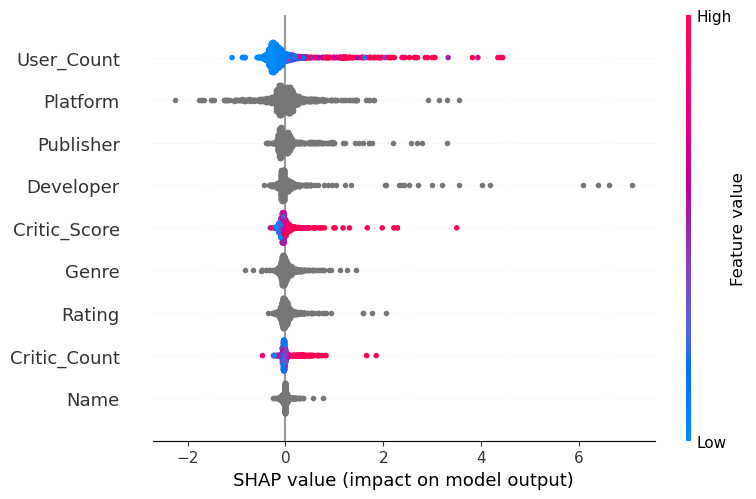

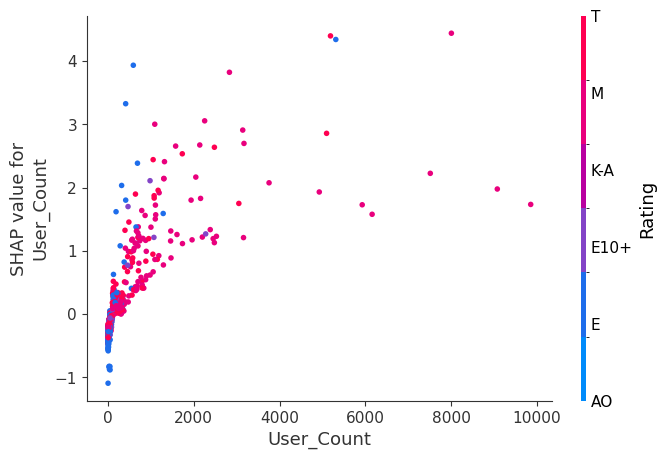

In [11]:
import shap
shap.initjs()
# create an explainer object 
explainer = shap.Explainer(model_c)
shap_values = explainer.shap_values(X_test_c)
# Display the summary_plot using SHAP values and testing set.
shap.summary_plot(shap_values, X_test_c)

# Dependence Plot for a specific feature
shap.dependence_plot('User_Count', shap_values, X_test_c)

# Force Plot for a specific instance
instance_index = 0  # Choose the instance index you want to analyze
shap.force_plot(explainer.expected_value, shap_values[instance_index], X_test_c.iloc[instance_index])

# Grey represents categorical values which cannot be scaled in high or low.
# High User_Count counts (red) are at a higher shap value, which means higher counts tend to positively affect the output.
# This was visible in the correlation matrix in the EDA.